# Naive Bayes

The purpose of this notebook is to read in the [UCI mushroom dataset](https://archive.ics.uci.edu/ml/datasets/Mushroom) and apply Naive Bayes Classification.

* Learn about Naive Bayes and include the basic principles in Markdown
* Import dataset both locally and directly from the web
* Make a few simple plots looking at the dataset


In [16]:
#import pandas and numpy libraries
import pandas as pd
import numpy as np
import sys #sys needed only for python version
#import gaussian naive bayes from scikit-learn
import sklearn as sk

#display versions of python and packages
print('\npython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('numpy version ' + np.__version__)
print('sk-learn version ' + sk.__version__)


python version 3.5.1 |Anaconda 2.5.0 (64-bit)| (default, Jan 29 2016, 15:01:46) [MSC v.1900 64 bit (AMD64)]
pandas version 0.17.1
numpy version 1.10.4
sk-learn version 0.17


In [23]:
# Read in data. it's comma-separated with no column names.
df = pd.read_csv('datasets/mushroom/agaricus-lepiota.data', sep=',', header=None,
                 error_bad_lines=False, warn_bad_lines=True, low_memory=False)

#manually add column names from documentation (1st col is class: e=edible,p=poisonous; rest are attributes)
df.columns = ['class','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
             'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
             'stalk-surf-above-ring','stalk-surf-below-ring','stalk-color-above-ring','stalk-color-below-ring',
             'veil-type','veil-color','ring-number','ring-type','spore-color','population','habitat']

In [24]:
print(df.head())

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color   ...   stalk-surf-below-ring  \
0            c         n          k   ...                       s   
1            c         b          k   ...                       s   
2            c         b          n   ...                       s   
3            c         n          n   ...                       s   
4            w         b          k   ...                       s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

e    4208
p    3916
Name: class, dtype: int64


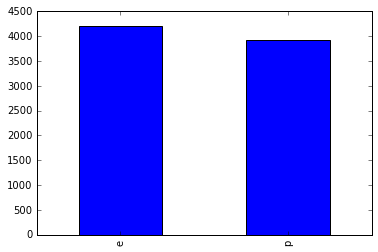

In [25]:
#show plots in notebook
%matplotlib inline

#bar chart of classes using pandas plotting
print(df['class'].value_counts())
df['class'].value_counts().plot(kind='bar')